In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')




Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']


In [2]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales
monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de fees donde 'stat_fe' == 'accepted'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),

    # Calcular total de adelantos, donde 'cash_request_received_date' no es nulo
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'regular' y 'stat_fe' == 'accepted'
    total_fees_regular=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'regular') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum()),
    
    # Calcular total de adelantos donde 'transfer_type' == 'regular' y 'cash_request_received_date' no es nulo
    total_adelantos_regular=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'regular']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    
    # Calcular total de adelantos donde 'transfer_type' == 'instant' y 'cash_request_received_date' no es nulo
    total_adelantos_instant=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'instant']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'instant' y 'stat_fe' == 'accepted'
    total_fees_instant=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'instant') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum())
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

# Calcular el ratio de fees sobre adelantos para transferencias 'regular'
monthly_data['fees_ratio_regular'] = (
    monthly_data['total_fees_regular'] / monthly_data['total_adelantos_regular'] * 100
)

# Calcular el ratio de fees sobre adelantos para transferencias 'instant'
monthly_data['fees_ratio_instant'] = (
    monthly_data['total_fees_instant'] / monthly_data['total_adelantos_instant'] * 100
)

# Mostrar la evolución mensual
print(monthly_data)

   Mes_created_at  total_fees  total_adelantos  total_fees_regular  \
0         2019-11         0.0              0.0                 0.0   
1         2019-12         0.0          16349.0                 0.0   
2         2020-01         0.0          10579.0                 0.0   
3         2020-02         0.0          10625.0                 0.0   
4         2020-03         0.0          16200.0                 0.0   
5         2020-04         0.0          31333.0                 0.0   
6         2020-05       520.0          57223.0               520.0   
7         2020-06      4685.0         153973.0              4685.0   
8         2020-07      5160.0         184061.0              4130.0   
9         2020-08     11695.0         178451.0               850.0   
10        2020-09     16785.0         224121.0               310.0   
11        2020-10     34840.0         459082.0               225.0   

    total_adelantos_regular  total_adelantos_instant  total_fees_instant  \
0            

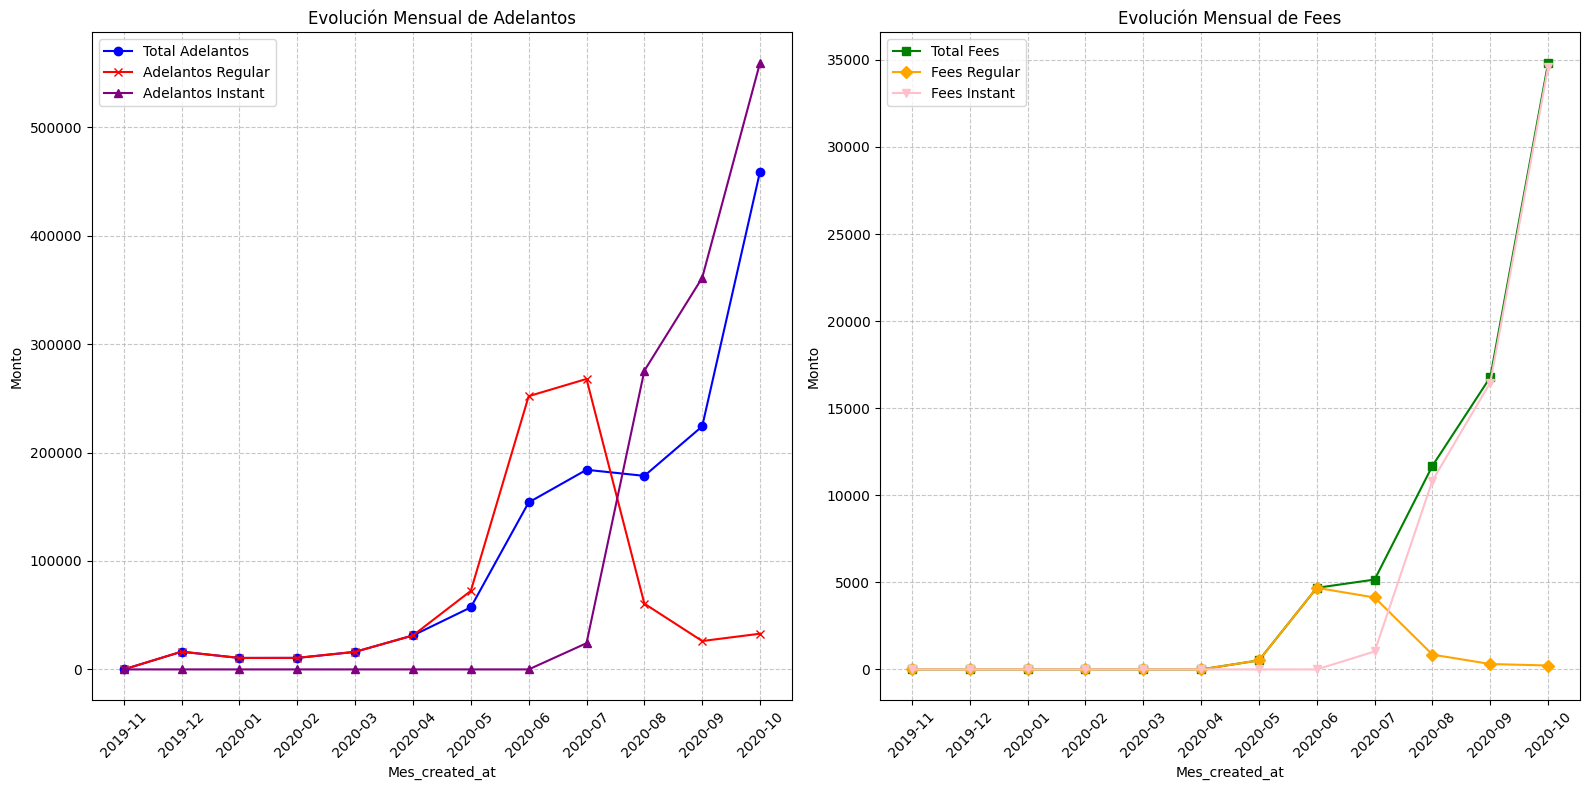

In [4]:
# Crear la figura y los ejes para dos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Graficar adelantos en el primer gráfico
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos_regular'], 
    marker='x', 
    label='Adelantos Regular', 
    color='red'
)
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos_instant'], 
    marker='^', 
    label='Adelantos Instant', 
    color='purple'
)

# Configurar etiquetas y título para el gráfico de adelantos
ax1.set_xlabel('Mes_created_at')
ax1.set_ylabel('Monto')
ax1.set_title('Evolución Mensual de Adelantos')
ax1.legend()  # Mostrar la leyenda para las líneas
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Graficar fees en el segundo gráfico
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees_regular'], 
    marker='D', 
    label='Fees Regular', 
    color='orange'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees_instant'], 
    marker='v', 
    label='Fees Instant', 
    color='pink'
)

# Configurar etiquetas y título para el gráfico de fees
ax2.set_xlabel('Mes_created_at')
ax2.set_ylabel('Monto')
ax2.set_title('Evolución Mensual de Fees')
ax2.legend()  # Mostrar la leyenda para las líneas
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Ajustar el layout para que todo se vea bien
plt.tight_layout()

# Mostrar los gráficos
plt.show()


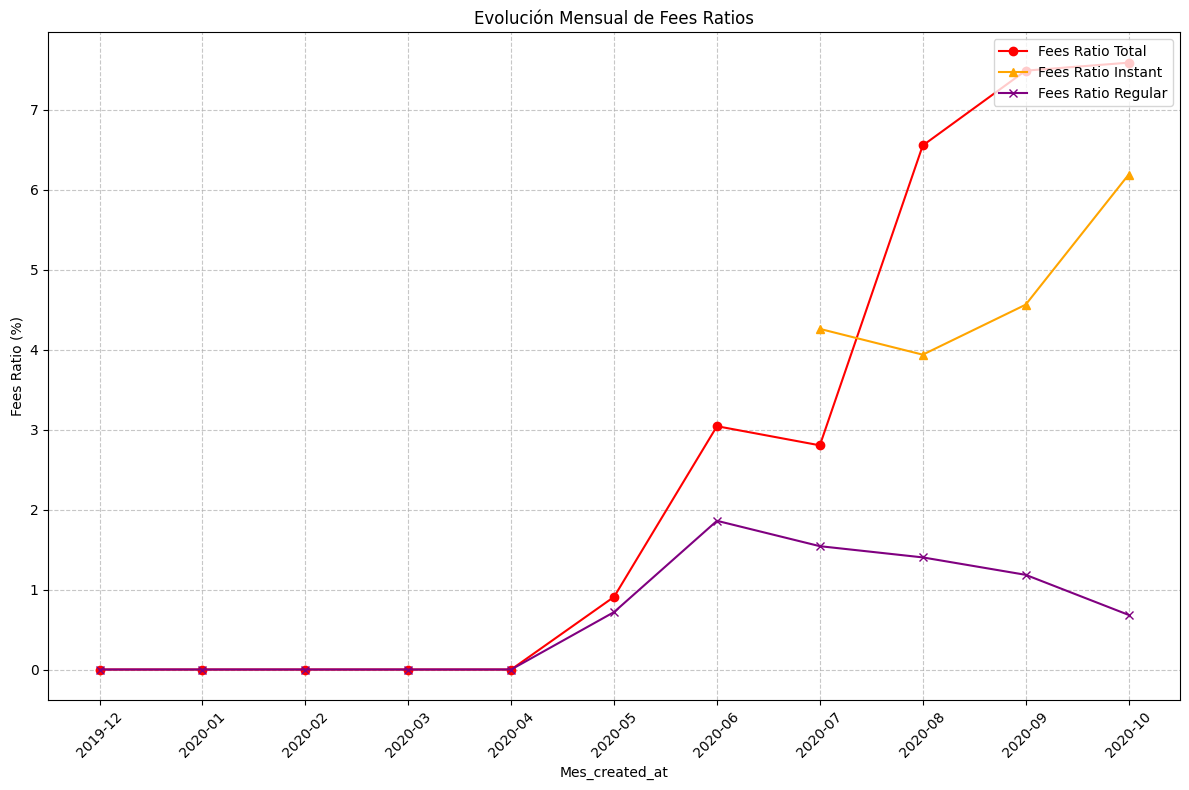

In [5]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los tres ratios en el eje principal
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio'], 
    marker='o', 
    label='Fees Ratio Total', 
    color='red'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_instant'], 
    marker='^', 
    label='Fees Ratio Instant', 
    color='orange'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_regular'], 
    marker='x', 
    label='Fees Ratio Regular', 
    color='purple'
)

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Fees Ratio (%)')
ax.set_title('Evolución Mensual de Fees Ratios')
ax.legend(loc='upper right')  # Mostrar la leyenda
ax.grid(True, linestyle='--', alpha=0.7)

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()
